In [1]:
from src.Data import Data
from src.Camera import Camera
from src.VisualOdometry import VisualOdometry
from src.data_association import *
from src.utils import *

import cv2
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go   

In [2]:
data = Data()
camera = Camera()

In [3]:
index = 2
world_map = data.get_world_data()
measurement = data.get_measurements_data_points(index)
trajectory = data.get_trajectory_data()
pose_1 = v2T([0, 0, trajectory[index][0], 0, 0, 0])
camera.set_c_T_w(np.linalg.inv(pose_1))

In [4]:
matches = data_association_on_appearance(measurement, world_map)

image_points = matches['points_1'] # world map
world_points = matches['points_2'] # measurements

projected_points = []
for i in range(len(world_points)):
    world_point_hom = np.append(world_points[i], 1)
    world_point_in_camera = np.linalg.inv(camera.get_camera_transform()) @ world_point_hom
    world_point_in_camera = world_point_in_camera[:3] / world_point_in_camera[3]
    
    is_inside, projected_point = camera.project_point(world_point_in_camera)
    if is_inside: projected_points.append(projected_point)

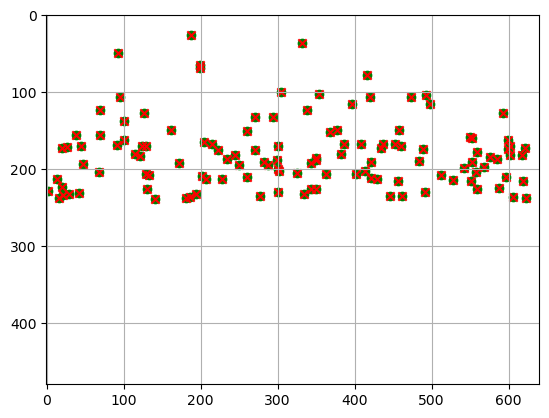

In [5]:
fig, ax = plt.subplots()
ax.imshow(np.ones((480, 640, 3)))
ax.scatter([point[0] for point in projected_points], [point[1] for point in projected_points], color='green', marker='o')
ax.scatter([point[0] for point in image_points], [point[1] for point in image_points], color='red', marker='x')
plt.grid()
plt.show()

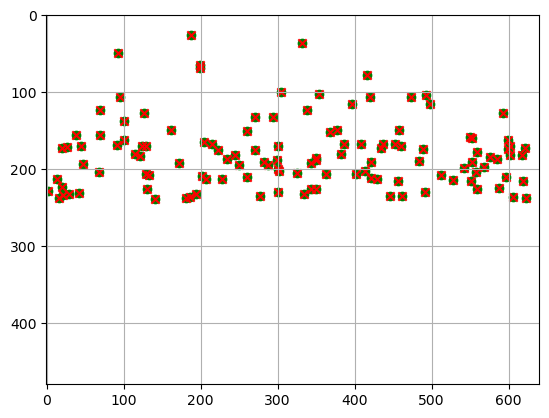

In [6]:
world_points_in_camera = []
for i in range(len(world_points)):
    world_point_hom = np.append(world_points[i], 1)
    world_point_in_camera = np.linalg.inv(camera.get_camera_transform()) @ world_point_hom
    world_point_in_camera = world_point_in_camera[:3] / world_point_in_camera[3]
    world_points_in_camera.append(world_point_in_camera)


projected_points = camera.project_points(world_points_in_camera)
projected_points = {'position':projected_points, 'appearance':world_map['appearance']}
matches = data_association_on_distance(measurement, projected_points)

image_points = matches['points_1'] # world map
projected_points = matches['points_2'] # measurements

fig, ax = plt.subplots()
ax.imshow(np.ones((480, 640, 3)))
ax.scatter([point[0] for point in projected_points], [point[1] for point in projected_points], color='green', marker='o')
ax.scatter([point[0] for point in image_points], [point[1] for point in image_points], color='red', marker='x')
plt.grid()
plt.show()


In [7]:
import pandas as pd
df = pd.DataFrame(matches)  
df

,points_1,points_2
0,"[300.051, 199.734]","[300.0505936224437, 199.73337753558624]"
1,"[558.968, 178.482]","[558.9676767952408, 178.48254219481248]"
2,"[492.844, 103.408]","[492.84428246013664, 103.40774487471526]"
3,"[44.5461, 169.677]","[44.54632497629274, 169.67691569407674]"
4,"[304.115, 99.833]","[304.115220559999, 99.83309865843029]"
...,...,...
118,"[260.672, 209.918]","[260.6724704542493, 209.91776895198845]"
119,"[604.982, 235.883]","[604.9818816103891, 235.88301791673805]"
120,"[299.616, 188.028]","[299.6161395317674, 188.0285284067467]"
121,"[343.475, 192.084]","[343.47472924187724, 192.0839018639947]"


In [8]:
vo = VisualOdometry()

vo.initialize()

In [9]:
pose_0 = vo.get_trajectory()[0]
pose_1 = vo.get_trajectory()[1]

world_points = vo.get_map()['position']
print('Number of world points: ', len(world_points))

x_coords = [point[0] for point in world_points]
y_coords = [point[1] for point in world_points]
z_coords = [point[2] for point in world_points]

fig = go.Figure()
fig.add_trace(go.Scatter3d(x=x_coords, y=y_coords, z=z_coords, mode='markers', marker=dict(size=2)))

fig.add_trace(go.Scatter3d(x=[pose_0[0, 3]], y=[pose_0[1, 3]], z=[pose_0[2, 3]], mode='markers', marker=dict(size=4, color='red')))
fig.add_trace(go.Scatter3d(x=[pose_1[0, 3]], y=[pose_1[1, 3]], z=[pose_1[2, 3]], mode='markers', marker=dict(size=4, color='blue')))
fig.add_trace(go.Scatter3d(x=[pose_0[0, 3], pose_1[0, 3]], y=[pose_0[1, 3], pose_1[1, 3]], z=[pose_0[2, 3], pose_1[2, 3],], mode='lines', line=dict(color='black', width=2)))

fig.show()

Number of world points:  115


In [10]:
trajectory = data.get_trajectory_data()
triangulated_points = {'position':[], 'appearance':[]}
triangulations = []

pose_0 = vo.get_trajectory()[0]
pose_1 = vo.get_trajectory()[1]

measurement_0 = data.get_measurements_data_points(0)
measurement_1 = data.get_measurements_data_points(1)
matches = data_association_on_appearance(measurement_0, measurement_1)
points_0 = np.array(matches['points_1'])
points_1 = np.array(matches['points_2'])
points_3D = vo.triangulate_points(points_0, points_1, pose_0, pose_1)
map = {'position':points_3D, 'appearance':matches['appearance']}

triangulations.append(map)
for i in range(len(map['position'])):
    if map['appearance'][i] not in triangulated_points['appearance']:
        triangulated_points['position'].append(map['position'][i])
        triangulated_points['appearance'].append(map['appearance'][i])

for i in range(1,120):    
    print('Frame: ', i)
    vo.update(i)
    
    pose_i = vo.get_trajectory()[i]
    measurement_i = data.get_measurements_data_points(i)    
    
    matches = data_association_on_appearance(measurement_0, measurement_i)
    points_0 = np.array(matches['points_1'])
    points_1 = np.array(matches['points_2'])
    print('Number of matches: ', len(points_0))

    points_3D = vo.triangulate_points(points_0, points_1, pose_0, pose_i)
    print('Number of triangulated points: ', len(points_3D))
    map = {'position':points_3D, 'appearance':matches['appearance']}

    new_map = {'position':[], 'appearance':[]}  
    for i in range(len(map['position'])):
        if map['appearance'][i] not in triangulated_points['appearance']:
            new_map['position'].append(map['position'][i])
            new_map['appearance'].append(map['appearance'][i])

    triangulated_points['position'] += new_map['position']
    triangulated_points['appearance'] += new_map['appearance']
    triangulations.append(new_map)

    pose_0 = pose_i
    measurement_0 = measurement_i

    print()

Frame:  1
Frame: 1 - w_T_c1:
[[ 1.  0.  0.  0.]
 [-0.  1.  0. -0.]
 [-0. -0.  1.  2.]
 [ 0.  0.  0.  1.]]
Number of matches:  115
Number of triangulated points:  115

Frame:  2
Frame: 2 - w_T_c1:
[[ 1.  0.  0.  0.]
 [-0.  1. -0.  0.]
 [-0.  0.  1.  3.]
 [ 0.  0.  0.  1.]]
Number of matches:  117
Number of triangulated points:  117

Frame:  3
Frame: 3 - w_T_c1:
[[ 1.  0.  0.  0.]
 [-0.  1. -0. -0.]
 [-0.  0.  1.  4.]
 [ 0.  0.  0.  1.]]
Number of matches:  118
Number of triangulated points:  118

Frame:  4
Frame: 4 - w_T_c1:
[[ 1.  0.  0. -0.]
 [-0.  1.  0.  0.]
 [-0. -0.  1.  5.]
 [ 0.  0.  0.  1.]]
Number of matches:  104
Number of triangulated points:  104

Frame:  5
Frame: 5 - w_T_c1:
[[ 1.  0.  0.  0.]
 [-0.  1. -0.  0.]
 [-0.  0.  1.  6.]
 [ 0.  0.  0.  1.]]
Number of matches:  96
Number of triangulated points:  96

Frame:  6
Frame: 6 - w_T_c1:
[[ 1.  0.  0.  0.]
 [-0.  1.  0. -0.]
 [-0. -0.  1.  7.]
 [ 0.  0.  0.  1.]]
Number of matches:  96
Number of triangulated points:  96

Fr

In [11]:
print('Number of triangulated points: ', len(triangulated_points['position']))

fig = go.Figure()

x_coords = [point[0] for point in triangulated_points['position']]  
y_coords = [point[1] for point in triangulated_points['position']]
z_coords = [point[2] for point in triangulated_points['position']]
fig.add_trace(go.Scatter3d(x=x_coords, y=y_coords, z=z_coords, mode='markers', marker=dict(size=3.5)))

first_triangulation = triangulations[0]
print('Number of points in first triangulation: ', len(first_triangulation['position']))
x_coords = [point[0] for point in first_triangulation['position']]
y_coords = [point[1] for point in first_triangulation['position']]
z_coords = [point[2] for point in first_triangulation['position']]
fig.add_trace(go.Scatter3d(x=x_coords, y=y_coords, z=z_coords, mode='markers', marker=dict(size=2, color='yellow')))

last_triangulation = triangulations[-1]
print('Number of points in last triangulation: ', len(last_triangulation['position']))
x_coords = [point[0] for point in last_triangulation['position']]
y_coords = [point[1] for point in last_triangulation['position']]
z_coords = [point[2] for point in last_triangulation['position']]
fig.add_trace(go.Scatter3d(x=x_coords, y=y_coords, z=z_coords, mode='markers', marker=dict(size=2, color='red')))

for pose in vo.get_trajectory():
    t = pose[:3, 3]
    fig.add_trace(go.Scatter3d(x=[t[0]], y=[t[1]], z=[t[2]], mode='markers', marker=dict(size=2, color='green')))
fig.show()

Number of triangulated points:  488
Number of points in first triangulation:  115
Number of points in last triangulation:  4


Pose_0: 
 [[ 1.000e+00  0.000e+00  0.000e+00  1.000e-02]
 [-0.000e+00  1.000e+00 -0.000e+00  0.000e+00]
 [-0.000e+00  0.000e+00  1.000e+00  1.599e+01]
 [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]]
Pose_1: 
 [[ 1.000e+00  0.000e+00  0.000e+00  1.000e-02]
 [-0.000e+00  1.000e+00 -0.000e+00  0.000e+00]
 [-0.000e+00  0.000e+00  1.000e+00  1.599e+01]
 [ 0.000e+00  0.000e+00  0.000e+00  1.000e+00]]
GT Pose_0: 
 [[ 0.37 -0.93  0.    4.04]
 [ 0.93  0.37  0.    0.54]
 [ 0.    0.    1.    0.  ]
 [ 0.    0.    0.    1.  ]]
GT Pose_1: 
 [[ 0.18 -0.98  0.    4.09]
 [ 0.98  0.18  0.    0.7 ]
 [ 0.    0.    1.    0.  ]
 [ 0.    0.    0.    1.  ]]
Number of matches:  63


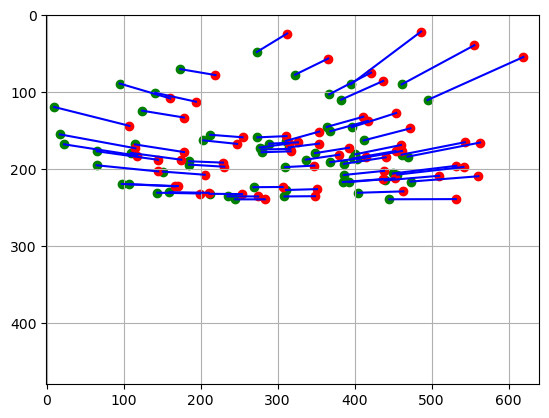

In [12]:
index = 22

pose_0 = vo.get_trajectory()[index]
pose_1 = vo.get_trajectory()[index+1]
print('Pose_0: \n', np.round(pose_0, 2))
print('Pose_1: \n', np.round(pose_1, 2))

gt_pose_0 = data.get_trajectory_data()[index]
gt_pose_0 = v2T([gt_pose_0[0], gt_pose_0[1], 0, 0, 0, gt_pose_0[2]])

gt_pose_1 = data.get_trajectory_data()[index+1]
gt_pose_1 = v2T([gt_pose_1[0], gt_pose_1[1], 0, 0, 0, gt_pose_1[2]])

print('GT Pose_0: \n', np.round(gt_pose_0, 2)) 
print('GT Pose_1: \n', np.round(gt_pose_1, 2))

image_points_0 = data.get_measurements_data_points(index)
image_points_1 = data.get_measurements_data_points(index+1)

matches = data_association_on_appearance(image_points_0, image_points_1)
image_points_0 = np.array(matches['points_1'])
image_points_1 = np.array(matches['points_2'])
print('Number of matches: ', len(image_points_0))

fig, ax = plt.subplots()
ax.imshow(np.ones((480, 640, 3)))
ax.scatter([point[0] for point in image_points_0], [point[1] for point in image_points_0], color='green', marker='o')
ax.scatter([point[0] for point in image_points_1], [point[1] for point in image_points_1], color='red', marker='o')

for i in range(len(image_points_0)):
    x = [image_points_0[i][0], image_points_1[i][0]]
    y = [image_points_0[i][1], image_points_1[i][1]]
    ax.plot(x, y, color='blue')
plt.grid()
plt.show()

gt_world_data = data.get_world_data()
matches = data_association_on_appearance(triangulations[index], gt_world_data)
triangulated_points = matches['points_1']
gt_world_points = matches['points_2']

triangulated_points_hom = [np.append(point, 1) for point in triangulated_points]
triangulated_points_world = camera.get_camera_transform() @ np.array(triangulated_points_hom).T
triangulated_points_world = triangulated_points_world.T

fig = go.Figure()
scale = 0.2056
x_coords = [point[0]*scale for point in triangulated_points_world]  
y_coords = [point[1]*scale for point in triangulated_points_world]
z_coords = [point[2]*scale for point in triangulated_points_world]
fig.add_trace(go.Scatter3d(x=x_coords, y=y_coords, z=z_coords, mode='markers', marker=dict(size=2, color='blue')))

x_coords_gt = [point[0] for point in gt_world_points]
y_coords_gt = [point[1] for point in gt_world_points]
z_coords_gt = [point[2] for point in gt_world_points]
fig.add_trace(go.Scatter3d(x=x_coords_gt, y=y_coords_gt, z=z_coords_gt, mode='markers', marker=dict(size=2, color='red')))

fig.show()